  Using cached scipy-1.16.0-cp312-cp312-macosx_14_0_arm64.whl.metadata (61 kB)
Using cached scipy-1.16.0-cp312-cp312-macosx_14_0_arm64.whl (20.8 MB)

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
import gym
from scipy.stats import beta

ModuleNotFoundError: No module named 'scipy'

In [15]:
df = pd.read_csv('updated_reviews.csv')
df = df[df['Score'] >= 0.0001]

df = df.copy()  
df['positive_gained'] = (df['Positive_Reviews'] > df['Positive_Reviews'].shift(1)).astype(int)
df = df[:-1]
df

,Score,Review_Count,Positive_Reviews,Days_Until_Release,positive_gained
1,0.9091,11,10,16,0
2,0.9167,12,11,16,1
3,0.9231,13,12,16,1
4,0.9286,14,13,16,1
5,0.9333,15,14,16,1
...,...,...,...,...,...
84,0.8361,122,102,-1,0
85,0.8306,124,103,-1,1
86,0.8320,125,104,-1,1
87,0.8217,129,106,-2,1


In [3]:
def beta_parameters_from_mean_and_variance(mu, sigma_squared):
    if mu <= 0 or mu >= 1:
        raise ValueError("Mean (mu) must be between 0 and 1 (exclusive).")
    if sigma_squared <= 0:
        raise ValueError("Variance must be positive.")
    
    v = mu * (1 - mu) / sigma_squared - 1
    alpha = mu * v
    beta = (1 - mu) * v
    return alpha, beta
def estimate_variance_from_reviews(mu, review_count):
    if review_count <= 0:
        raise ValueError("Review count must be positive.")
    return mu * (1 - mu) / review_count / 100


In [4]:
# Inputs from your DataFrame
mu = df.loc[10, 'Score']
n = df.loc[10, 'Review_Count']

# Estimate variance from binomial assumption
sigma2 = estimate_variance_from_reviews(mu, n)
print(mu, sigma2)
# Get alpha and beta
alpha, beta_param = beta_parameters_from_mean_and_variance(mu, sigma2)
print(f"alpha = {alpha}, beta = {beta_param}")


NameError: name 'df' is not defined

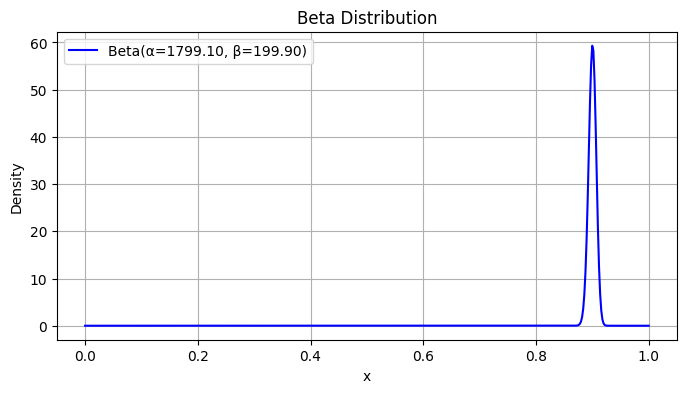

In [11]:
x = np.linspace(0, 1, 500)

pdf = beta.pdf(x, alpha, beta_param)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x, pdf, label=f'Beta(α={alpha:.2f}, β={beta_param:.2f})', color='blue')
plt.title("Beta Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.show()

In [12]:
import numpy as np
from scipy.stats import beta

def run_beta_monte_carlo(pos_reviews, total_reviews, steps=5, num_simulations=10000):
    """
    Simulates review evolution using Beta distribution posterior.
    Starts from (pos_reviews / total_reviews) and runs MC for `steps` steps.

    Returns:
        final_scores: Array of size num_simulations containing simulated final scores
    """
    alpha_0 = pos_reviews + 1  # +1 for Laplace smoothing (optional)
    beta_0 = (total_reviews - pos_reviews) + 1

    # Final state after n new reviews simulated
    final_scores = []

    for _ in range(num_simulations):
        alpha = alpha_0
        beta_param = beta_0

        for _ in range(steps):
            # Simulate a new review from the true underlying Beta distribution
            sampled_mu = np.random.beta(alpha, beta_param)
            new_review = np.random.binomial(1, sampled_mu)

            # Update posterior
            if new_review == 1:
                alpha += 1
            else:
                beta_param += 1

        final_score = alpha / (alpha + beta_param)
        final_scores.append(final_score)

    return np.array(final_scores)


Mean final score: 0.864
5th - 95th percentile: 0.732 - 0.960


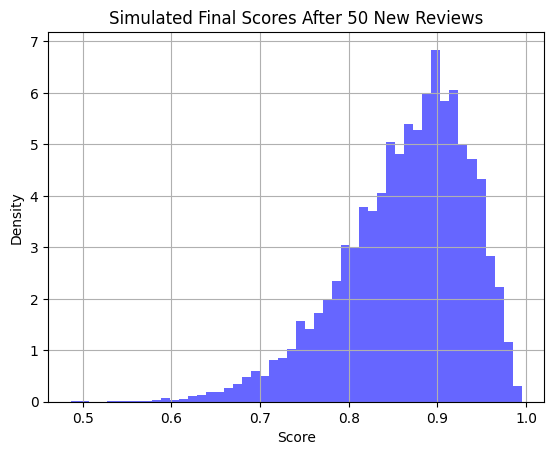

In [13]:
import matplotlib.pyplot as plt

# Run simulation
final_scores = run_beta_monte_carlo(pos_reviews=18, total_reviews=20, steps=1000)

# Summary stats
print(f"Mean final score: {np.mean(final_scores):.3f}")
print(f"5th - 95th percentile: {np.percentile(final_scores, 5):.3f} - {np.percentile(final_scores, 95):.3f}")

# Plot histogram
plt.hist(final_scores, bins=50, density=True, alpha=0.6, color='blue')
plt.title("Simulated Final Scores After 50 New Reviews")
plt.xlabel("Score")
plt.ylabel("Density")
plt.grid(True)
plt.show()


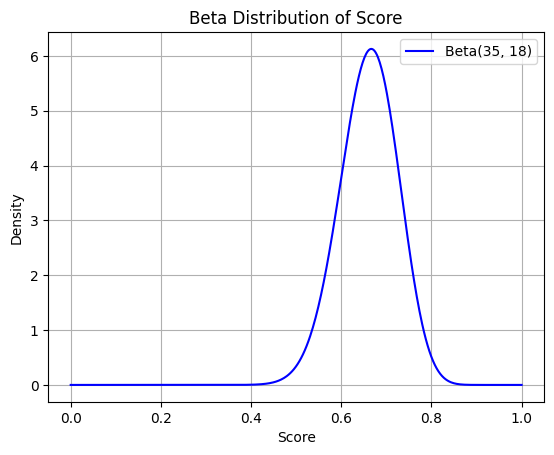

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Inputs
positive_reviews = 34
total_reviews = 51

# Compute alpha and beta (with Laplace smoothing)
alpha = positive_reviews + 1
beta_param = total_reviews - positive_reviews + 1

# Plot the Beta PDF
x = np.linspace(0, 1, 500)
pdf = beta.pdf(x, alpha, beta_param)

plt.plot(x, pdf, label=f'Beta({alpha}, {beta_param})', color='blue')
plt.title("Beta Distribution of Score")
plt.xlabel("Score")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.show()


Mean final score: 0.660
5th - 95th percentile: 0.619 - 0.698


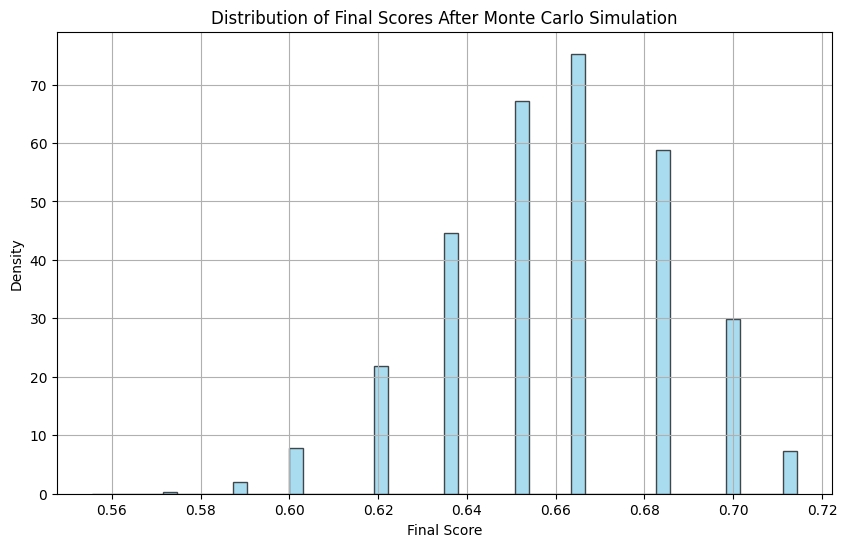

In [12]:

def monte_carlo_final_score(alpha, beta_param, n_new_reviews=10, num_samples=900000):
    # Sample true mu from current Beta posterior
    sampled_mus = np.random.beta(alpha, beta_param, size=num_samples)
    
    # For each mu, simulate new review outcomes
    new_pos = np.random.binomial(n_new_reviews, sampled_mus)
    
    # Update alpha and beta
    new_alpha = alpha + new_pos
    new_beta = beta_param + n_new_reviews - new_pos
    
    # Posterior means after new reviews
    final_scores = new_alpha / (new_alpha + new_beta)
    return final_scores

# Example usage:

final_score_samples = monte_carlo_final_score(alpha, beta_param)

# Summary stats
print(f"Mean final score: {final_score_samples.mean():.3f}")
print(f"5th - 95th percentile: {np.percentile(final_score_samples, 5):.3f} - {np.percentile(final_score_samples, 95):.3f}")

# Run simulation
final_score_samples = monte_carlo_final_score(alpha, beta_param)

# Plot histogram of final scores
plt.figure(figsize=(10,6))
plt.hist(final_score_samples, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.title("Distribution of Final Scores After Monte Carlo Simulation")
plt.xlabel("Final Score")
plt.ylabel("Density")
plt.grid(True)
plt.show()

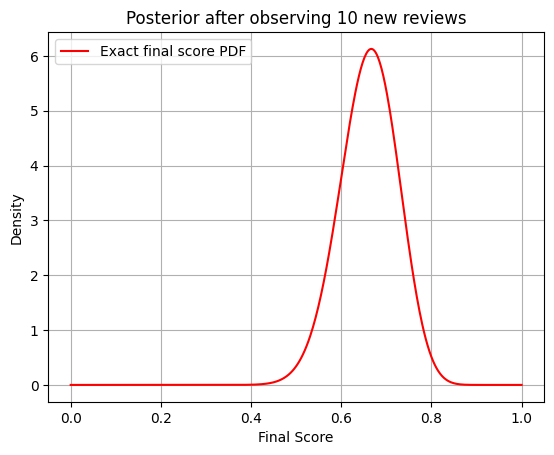

In [13]:
import numpy as np
from scipy.stats import beta, betabinom
import matplotlib.pyplot as plt
from scipy.special import betaln

def beta_binomial_pmf(k, n, alpha, beta_param):
    # Log Beta function for numerical stability
    # P(K=k) = comb(n, k) * B(alpha+k, beta+n-k) / B(alpha, beta)
    # Using betaln for log beta function
    from scipy.special import comb, betaln
    log_p = np.log(comb(n, k)) + betaln(alpha + k, beta_param + n - k) - betaln(alpha, beta_param)
    return np.exp(log_p)

def final_score_pdf(x, alpha, beta_param, n_new):
    # x can be array of points to evaluate the PDF at
    pdf_vals = np.zeros_like(x, dtype=float)
    for k in range(n_new + 1):
        weight = beta_binomial_pmf(k, n_new, alpha, beta_param)
        pdf_component = beta.pdf(x, alpha + k, beta_param + n_new - k)
        pdf_vals += weight * pdf_component
    return pdf_vals


n_new = 10
# Evaluation points
x = np.linspace(0, 1, 500)
pdf = final_score_pdf(x, alpha, beta_param, n_new)

plt.plot(x, pdf, label='Exact final score PDF', color='red')
plt.title(f'Posterior after observing {n_new} new reviews')
plt.xlabel('Final Score')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()


In [15]:
import numpy as np
from scipy.stats import beta, betabinom
from scipy.special import comb, betaln

def beta_binomial_pmf(k, n, alpha, beta_param):
    # Using betaln for numerical stability
    log_p = np.log(comb(n, k)) + betaln(alpha + k, beta_param + n - k) - betaln(alpha, beta_param)
    return np.exp(log_p)

def mixture_mean(alpha, beta_param, n_new):
    mean = 0.0
    denom = alpha + beta_param + n_new
    for k in range(n_new + 1):
        weight = beta_binomial_pmf(k, n_new, alpha, beta_param)
        mean += weight * (alpha + k) / denom
    return mean

def mixture_cdf(x, alpha, beta_param, n_new):
    cdf_val = 0.0
    for k in range(n_new + 1):
        weight = beta_binomial_pmf(k, n_new, alpha, beta_param)
        cdf_val += weight * beta.cdf(x, alpha + k, beta_param + n_new - k)
    return cdf_val

def mixture_prob_range(a, b, alpha, beta_param, n_new):
    return mixture_cdf(b, alpha, beta_param, n_new) - mixture_cdf(a, alpha, beta_param, n_new)



mean = mixture_mean(alpha, beta_param, n_new)
print(f"Mean of final score: {mean:.4f}")

# Probability final score ≤ 0.75
initial = mixture_cdf(0.655, alpha, beta_param, n_new)
print(f"P(final score ≤ 0.524) = {initial:.4f}")

# Probability final score in [0.6, 0.8]
p_range = mixture_prob_range(0.0, 0.875, alpha, beta_param, n_new)
print(f"P(0.6 ≤ final score ≤ 0.8) = {p_range:.4f}")


Mean of final score: 0.6604
P(final score ≤ 0.524) = 0.4550
P(0.6 ≤ final score ≤ 0.8) = 1.0000


Mean final score: 0.7091
5th–95th percentile: 0.5842 – 0.8020


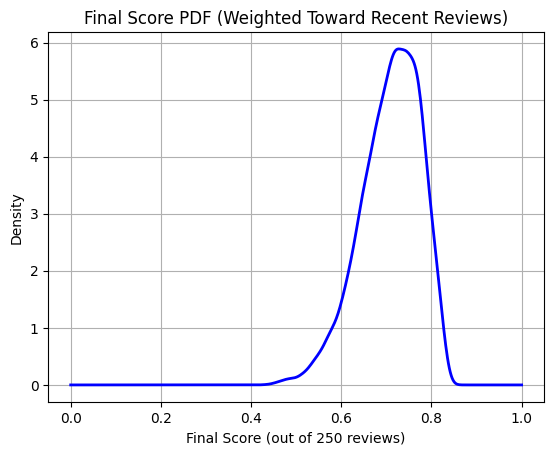

In [16]:
#Rolling window with lower mean!!




def biased_trend_monte_carlo(
    historical_pos, historical_total,
    recent_pos, recent_total,
    future_reviews=50,
    num_simulations=10000
):
    # Use recent data to model future trend
    alpha = recent_pos + 1
    beta_param = recent_total - recent_pos + 1
    
    # Sample future mean positive rates
    sampled_mus = np.random.beta(alpha, beta_param, size=num_simulations)
    
    # Simulate new positive review counts
    new_pos = np.random.binomial(n=future_reviews, p=sampled_mus)
    
    # Combine with historical fixed data
    final_scores = (historical_pos + new_pos) / (historical_total + future_reviews)
    
    return final_scores

# Inputs
final_scores = biased_trend_monte_carlo(
    historical_pos=34, historical_total=51,
    recent_pos=8, recent_total=10,
    future_reviews=50
)

# Summary stats
print(f"Mean final score: {final_scores.mean():.4f}")
print(f"5th–95th percentile: {np.percentile(final_scores, 5):.4f} – {np.percentile(final_scores, 95):.4f}")

# Plot PDF estimate
from scipy.stats import gaussian_kde
x = np.linspace(0, 1, 500)
kde = gaussian_kde(final_scores)
pdf = kde.evaluate(x)

plt.plot(x, pdf, color='blue', lw=2)
plt.title("Final Score PDF (Weighted Toward Recent Reviews)")
plt.xlabel("Final Score (out of 250 reviews)")
plt.ylabel("Density")
plt.grid(True)
plt.show()


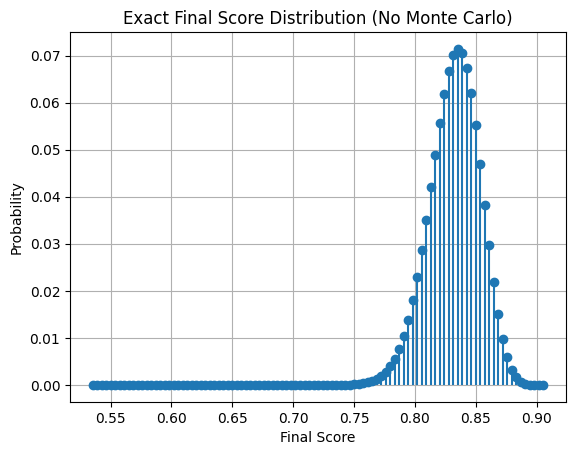

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import betabinom


# Fixed part: 100 positives out of 200
fixed_pos = 144.5
fixed_total = 170

# Future reviews modeled with Beta(9, 18)
alpha = 81
beta_param = 20
future_reviews = 100

# Compute Beta-Binomial PMF for each possible number of future positives
k_values = np.arange(future_reviews + 1)
bb_pmf = betabinom.pmf(k_values, future_reviews, alpha, beta_param)

# Final score is (100 + k) / total
final_score_x = (fixed_pos + k_values) / (fixed_total + future_reviews)

# This is the exact PDF (technically PMF) of final scores
plt.stem(final_score_x, bb_pmf, basefmt=" ")
plt.title("Exact Final Score Distribution (No Monte Carlo)")
plt.xlabel("Final Score")
plt.ylabel("Probability")
plt.grid(True)
plt.show()


P(final score ≤ {s_thresh}): 0.36321141224339176


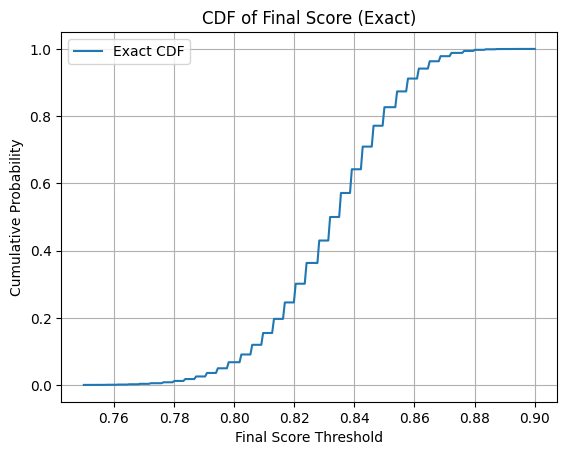

In [33]:
import numpy as np
from scipy.stats import betabinom

def exact_final_score_cdf(s_thresh, fixed_pos, fixed_total, future_reviews, alpha, beta_param):
    """
    Computes the exact CDF of the final score at a given threshold s_thresh.
    
    Parameters:
    - s_thresh: scalar or array of score thresholds in [0, 1]
    """
    s_thresh = np.atleast_1d(s_thresh)
    
    # Discrete possible k values: new positives (0 to 50)
    k_values = np.arange(future_reviews + 1)
    
    # Corresponding final scores
    final_scores = (fixed_pos + k_values) / (fixed_total + future_reviews)
    
    # PMF of future positives
    pmf = betabinom.pmf(k_values, future_reviews, alpha, beta_param)

    # For each threshold, sum PMFs for scores <= that threshold
    cdf_vals = np.array([
        np.sum(pmf[final_scores <= s]) for s in s_thresh
    ])

    return cdf_vals if len(cdf_vals) > 1 else cdf_vals[0]
# Single value
s_thresh = 0.825
params = {
    "s_thresh": s_thresh,
    "fixed_pos": fixed_pos,
    "fixed_total": fixed_total,
    "future_reviews": future_reviews,
    "alpha": alpha,
    "beta_param": beta_param,
}

exact_final_score_cdf(**params)


print("P(final score ≤ {s_thresh}):", exact_final_score_cdf(**params))
                                                            

# Range of CDFs
x = np.linspace(0.75, 0.90, 250)

# Update only the s_thresh value in your params
params["s_thresh"] = x
cdf_vals = exact_final_score_cdf(**params)

plt.plot(x, cdf_vals, label='Exact CDF')
plt.title("CDF of Final Score (Exact)")
plt.xlabel("Final Score Threshold")
plt.ylabel("Cumulative Probability")
plt.grid(True)
plt.legend()
plt.show()

